In [28]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import os
import matplotlib.pyplot as plt
import cv2
from skimage import filters, color, morphology
from skimage.segmentation import flood, flood_fill


from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage



# [IAPR][iapr]: Project


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 27.04.2023


## Important notes

The assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Introduction

In this project, you will be working on solving tiling puzzles using image analysis and pattern recognition techniques. Tiling puzzles are a classic type of puzzle game that consists of fitting together pieces of a given shape (in this case squared to form a complete image. The goal of this project is to develop an algorithm that can automatically reconstruct tiling puzzles from a single input image. 

---

## 1. Data

### Input data
To achieve your task, you will be given images that look like this:


![train_00.png](data_project/project_description/train_00.png)

### Example puzzle content
Example of input of solved puzzles. 
Solution 1
<img src="data_project/project_description/solution_example.png" width="512"/>
Solution 2
<img src="data_project/project_description/solution_example2.jpg" width="512"/>


### 1.1. Image layout

- The input for the program will be a single image with a size of __2000x2000 pixels__, containing the pieces of the tiling puzzles randomly placed in it. The puzzles sizes vary from __3x3, 3x4, or 4x4__ size. 
    -__You are guaranteed to always have the exact number of pieces for each puzzle__ 
        -For each puzzle you always are expected to find exaclty 9,12,16 pieces
        -If you find something else, either you are missing pieces, or added incorrect pieces for the puzzle

- The puzzle pieces are square-shaped with dimensions of 128x128 pixels (before rotation). 

- The input image will contain pieces from __two or three (but never four)__ different tiling puzzles, as well as some __extra pieces (outliers)__ that do not belong to either puzzle.


## 2. Tasks (Total 20 points) 


The project aims to:
1) Segment the puzzle pieces from the background (recover the pieces of 128x128 pixels)   \[ __5 points__ \] 

2) Extract features of interest from puzzle pieces images \[ __5 points__ \]   

3) Cluster puzzle pieces to identify which puzzle they belong, and identify outliers.  \[ __5 points__ \]   

4) Solve tiling puzzle (find the rotations and translations to correctly allocate the puzzle pieces in a 3x3, 3x4 or 4x4 array.) \[ __5 points__ \]   

##### The images used for the puzzles have self-repeating patterns or textures, which ensures that all puzzle pieces contain more or less the same features regardless of how they were cut. 




### 1.2. Output solution pieces.

For each inpute image, the output solution will include N images with solved puzzles, where N is the number of puzzles in the input image. and M images, that are Each of these images will contain the solved solution to one of the N puzzles in the input. 


-  Example input:  train_05.png

- Example solution:
        -solution_05_00.png solution_05_01.png solution_05_02.png 
        -outlier_05_00.png outlier_05_01.png outlier_05_02.png ...

- Example input:  train_07.png
- Example solution:
        -solution_07_00.png solution_07_01.png 
        -outlier_07_00.png outlier_07_01.png outlier_07_02.png ...


__Watch out!__ output resolution should always be like this:  
<table ><tr><th >Puzzle pieces <th><th> pixel dimentions <th> <th> pixel dimentions <th> <tr>
<tr><td> 3x3 <td><td> 384x384 <td><td> 3(128)x3(128) <td> <tr>
<tr><td> 3x4 <td><td> 384x512 <td><td> 3(128)x4(128)<tr>
<tr><td> 4x4 <td><td> 512x512 <td><td> 4(128)x4(128)<tr>
<tr><td> 1x1 (outlier)<td><td> 128x128 <td><td> (1)128x(1)128 <td><tr><table>





__Order of the solutions (and rotations) it's not a problem for the grading__




the output solution will be a final image of resolution (1283)x(1283), with each piece correctly placed in its corresponding location in the 3x3 array. Similarly, if the puzzle consists of 3x4 or 4x4 pieces, the output solution will be an image of resolution (1283)x(1284) or (1284)x(1284)



### 1.3 Data folder Structure

You can download the data for the project here: [download data](https://drive.google.com/drive/folders/1k3xTH0ZhpqZb3xcZ6wsOSjLzxBNYabg3?usp=share_link)

```
data_project
│
└─── project_description
│    │    example_input.png      # example input images
│    │    example_textures1.png      # example input images
│    │    example_textures2.png      # example input images
│    └─── ultimate_test.jpg   # If it works on that image, you would probably end up with a good score
│
└─── train
│    │    train_00.png        # Train image 00
│    │    ...
│    │    train_16.png        # Train image 16
│    └─── train_labels.csv    # Ground truth of the train set
|    
└────train_solution
│    │    solution_00_00.png        # Solution puzzle 1 from Train image 00
│    │    solution_00_01.png        # Solution puzzle 2 from Train image 00
│    │    solution_00_02.png        # Solution Puzzle 3 from Train image 00
│    │    outlier_00_00.png         # outlier     from Train image 00
│    │    outlier_00_01.png         # outlier     from Train image 00
│    │    outlier_00_03.png         # outlier     from Train image 00
│    │    ...
│    │    solution_15_00.png        # Solution puzzle 1 from Train image 15
│    │    solution_15_01.png        # Solution puzzle 2 from Train image 15
│    │    outlier_15_00.png         # outlier     from Train image 15
│    └─── outlier_15_01.png         # outlier     from Train image 15
│
└─── test
     │    test_00.png         # Test image 00 (day of the exam only)
     │    ...
     └─── test_xx.png             # Test image xx (day of the exam only)
```



## 3. Evaluation

**Before the exam**
   - Create a zipped folder named **groupid_xx.zip** that you upload on moodle (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam**
   - You will be given a **new folder** (test folder) with few images, but **no ground truth** (no solutions).
   - We will ask you to run your pipeline in **real time** and to send us your prediction of the task you obtain with the provided function **save_results**. 
   - On our side, we will compute the performance of your classification algorithm. 
   - To evaluate your method, we will use the **evaluate_solution** function presented below. To understand how the provided functions work, please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty on the day of the exam**. 
---


## 4. Your code

In [2]:
## load images
import os 
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt


In [3]:

def load_input_image(image_index ,  folder ="train2" , path = "../data_project"):
    
    filename = "train_{}.png".format(str(image_index).zfill(2))
    path_solution = os.path.join(path,folder , filename )
    
    im= Image.open(os.path.join(path,folder,filename)).convert('RGB')
    im = np.array(im)
    return im

def save_solution_puzzles(image_index , solved_puzzles, outliers  , folder ="train2" , path = "../data_project"  ,group_id = 0):
    
    path_solution = os.path.join(path,folder + "_solution_{}".format(str(group_id).zfill(2)))
    if not  os.path.isdir(path_solution):
        os.mkdir(path_solution)

    print(path_solution)
    for i, puzzle in enumerate(solved_puzzles):
        filename =os.path.join(path_solution, "solution_{}_{}.png".format(str(image_index).zfill(2), str(i).zfill(2)))
        Image.fromarray(puzzle).save(filename)

    for i , outlier in enumerate(outliers):
        filename =os.path.join(path_solution, "outlier_{}_{}.png".format(str(image_index).zfill(2), str(i).zfill(2)))
        Image.fromarray(outlier).save(filename)


In [4]:
def solve_and_export_puzzles_image(image_index , folder = "train2" , path = "../data_project"  , group_id = "00"):
    """
    Wrapper funciton to load image and save solution
            
    Parameters
    ----------
    image:
        index number of the dataset

    Returns
    """

      # open the image
    image_loaded = load_input_image(image_index , folder = folder , path = path)
    #print(image_loaded)
    
   
    ## call functions to solve image_loaded
    solved_puzzles = [ (np.random.rand(512,512,3)*255).astype(np.uint8)  for i in range(2) ]
    outlier_images = [ (np.random.rand(128,128,3)*255).astype(np.uint8) for i in range(3)]
    
    save_solution_puzzles (image_index , solved_puzzles , outlier_images , folder = folder ,group_id =group_id)
    
   
    
    
    
    return image_loaded , solved_puzzles , outlier_images

im, sol , out = solve_and_export_puzzles_image(6 , group_id = 6)

../data_project/train2_solution_06


In [5]:
group_id = 0
# Evaluate all images
games_id = [6,10]  # to evaluate  three images

for i in games_id :
    
    print("solving " , i)
    # Saving results
    solve_and_export_puzzles_image(6 , group_id = group_id)
  


solving  6
../data_project/train2_solution_00
solving  10
../data_project/train2_solution_00


## 4.1 Segmentation of the square pieces

In [6]:
def plot_image(image: np.ndarray, title: str = ''):

    # Convert the image from BGR to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate the histograms for each color channel
    hist_red = cv2.calcHist([image_rgb], [0], None, [256], [0, 256])
    hist_green = cv2.calcHist([image_rgb], [1], None, [256], [0, 256])
    hist_blue = cv2.calcHist([image_rgb], [2], None, [256], [0, 256])

    # Plot the histograms
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.plot(hist_red, color='red')
    plt.title('Red Histogram')
    plt.xlim([0, 256])
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.plot(hist_green, color='green')
    plt.title('Green Histogram')
    plt.xlim([0, 256])
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.plot(hist_blue, color='blue')
    plt.title('Blue Histogram')
    plt.xlim([0, 256])
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    # Add a joint title to the figure
    plt.suptitle(title)

    plt.tight_layout()
    plt.show()

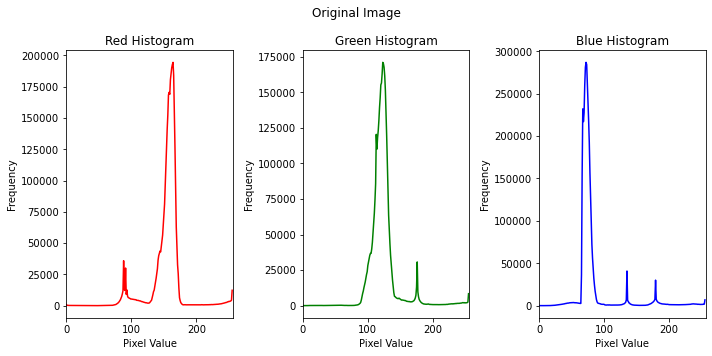

In [7]:
test_image = "../data_project/train2/train_00.png"
plot_image(cv2.imread(test_image), title='Original Image')

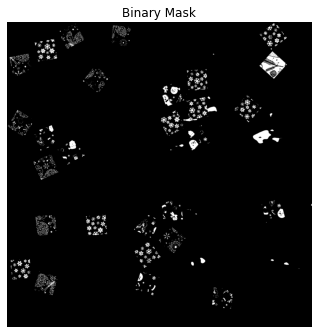

In [15]:
def test_segmentation(image):

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate the color histograms
    hist_red = cv2.calcHist([image_rgb], [0], None, [256], [0, 256])
    hist_green = cv2.calcHist([image_rgb], [1], None, [256], [0, 256])
    hist_blue = cv2.calcHist([image_rgb], [2], None, [256], [0, 256])

    # Find the peak intensity value in the histograms
    peak_value_red = np.argmax(hist_red)
    peak_value_green = np.argmax(hist_green)
    peak_value_blue = np.argmax(hist_blue)

    # Set a threshold value for background identification
    epsilon_threshold = 10
    below_limit = np.array([peak_value_red, peak_value_green, peak_value_blue]) - epsilon_threshold
    above_limit = np.array([peak_value_red, peak_value_green, peak_value_blue]) + epsilon_threshold
    
    # Create a binary mask based on the threshold
    mask1 = cv2.inRange(image_rgb, np.array([0, 0, 0]), below_limit)
    mask2 = cv2.inRange(image_rgb, above_limit, np.array([255, 255, 255]))
    mask = cv2.bitwise_or(mask1, mask2)

    # Plot the binary mask
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(mask, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')
    
test_segmentation(cv2.imread(test_image))


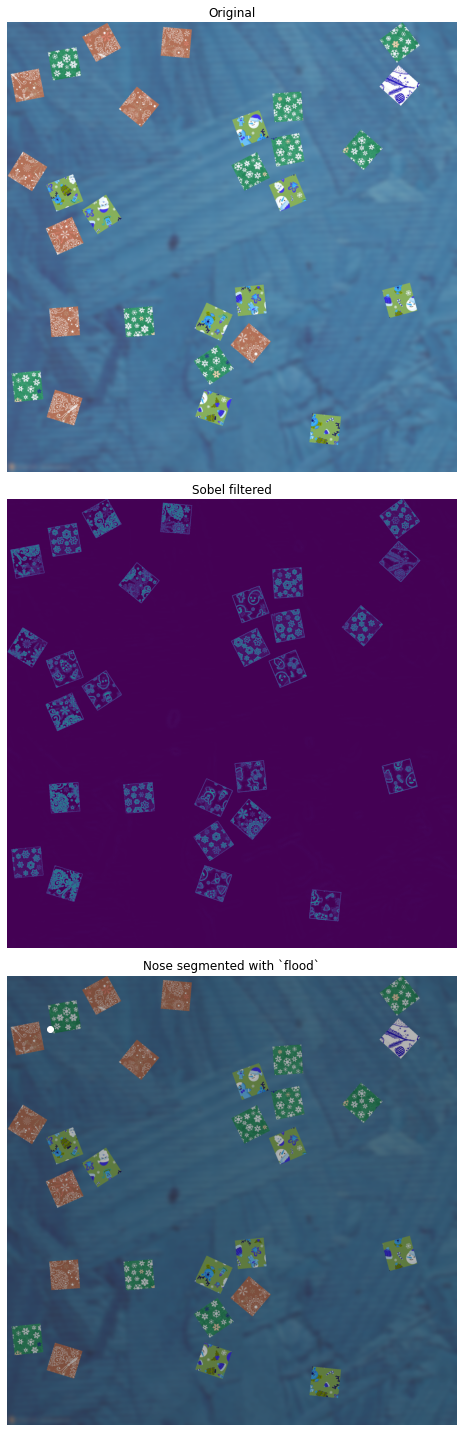

In [58]:
def get_seed_point(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate the color histograms
    hist_red = cv2.calcHist([image_rgb], [0], None, [256], [0, 256])

    # Find the peak intensity value in the histograms
    peak_value_red = np.argmax(hist_red)
    
    # Find pixels with the specified red channel value
    red_pixels = np.where(image[:, :, 0] == peak_value_red)

    # Randomly select an index from the red pixels
    random_index = np.random.choice(len(red_pixels[0]))

    # Get the coordinates of the randomly selected pixel
    x = red_pixels[0][random_index]
    y = red_pixels[1][random_index]

    # Get the RGB values of the selected pixel
    return [x,y]
    

def test_segmentation_flood(image):    
    
    seed_point = get_seed_point(image)
    image_sobel = filters.sobel(image[..., 2])
    background_mask = flood(image_sobel, seed_point=tuple(seed_point), tolerance=0.01)

    fig, ax = plt.subplots(nrows=3, figsize=(10, 20))

    ax[0].imshow(image)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].imshow(image_sobel)
    ax[1].set_title('Sobel filtered')
    ax[1].axis('off')

    ax[2].imshow(image)
    ax[2].imshow(background_mask, cmap=plt.cm.gray, alpha=0.3)
    ax[2].plot(seed_point[0], seed_point[1], 'wo')  # seed point
    ax[2].set_title('Nose segmented with `flood`')
    ax[2].axis('off')

    fig.tight_layout()
    plt.show()
    
test_segmentation_flood(cv2.imread(test_image))

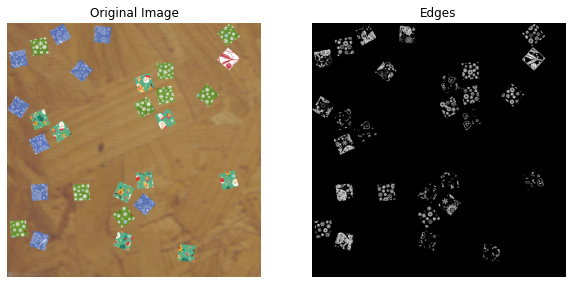

In [11]:
def test_segmentation_watershed(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a Gaussian filter
    filtered = cv2.GaussianBlur(gray, (3, 3), 0)

    # Compute the Laplacian of the filtered image
    laplacian = cv2.Laplacian(filtered, cv2.CV_64F)

    # Convert the Laplacian image to an appropriate type
    laplacian = cv2.convertScaleAbs(laplacian)

    # Threshold the Laplacian image
    _, edges = cv2.threshold(laplacian, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Display the original image and the detected edges
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edges')
    plt.axis('off')

    plt.show()

test_segmentation_watershed(cv2.imread(test_image))

In [21]:
def test_segmentation_sobel_contours(image):
    image_sobel = filters.sobel(image[..., 2])
    image_sobel = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply morphological operations to refine the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    mask = cv2.morphologyEx(image_sobel, cv2.MORPH_OPEN, kernel)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_area_threshold = 16000
    max_area_threshold = 20000
    
    print('Number of contours found: ', len(contours))
    # Iterate over the contours and filter based on area and aspect ratio
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h

        # Adjust the area and aspect ratio thresholds as per your requirements
        if area > min_area_threshold and area < max_area_threshold and aspect_ratio > 0.8 and aspect_ratio < 1.2:
            filtered_contours.append(contour)

    # Extract rotated bounding boxes and resize to 128x128 pixels
    squared_pieces = []
    for contour in filtered_contours:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # Extract the region of interest (ROI) from the original image
        roi = image[box[1][1]:box[0][1], box[1][0]:box[2][0]]
        
        # Resize the ROI to 128x128 pixels
        roi_resized = cv2.resize(roi, (128, 128))

        squared_pieces.append(roi_resized)

    # Display the resulting squared pieces
    for piece in squared_pieces:
        plt.figure(figsize=(3, 3))
        plt.imshow(cv2.cvtColor(piece, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

test_segmentation_sobel_contours(cv2.imread(test_image))

Number of contours found:  1


Number of contours found:  30
Number of filtered contours found:  19


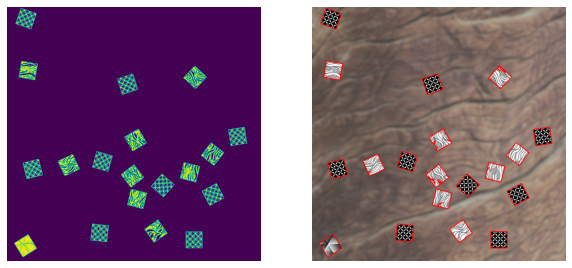

In [102]:
def get_color_channel(image):
    hist_red = cv2.calcHist([image], [2], None, [256], [0, 256])
    hist_green = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_blue = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Find the index of the channel with the highest peak value
    channel_peaks = [np.max(hist_red), np.max(hist_green), np.max(hist_blue)]
    return np.argmax(channel_peaks)
    
def test_segmentation_watershed(image, threshold=0.05):
    # Try to identify the color of the background
    color_channel = get_color_channel(image)
    
    #Filter the image using a Sobel filter
    image_sobel = filters.sobel(image[...,color_channel])
    
    markers = np.zeros_like(image_sobel)
    markers[image_sobel > threshold*image_sobel.max()] = 255
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(markers)
    plt.axis('off')
    
    mask = markers.astype(np.uint8)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    min_area_threshold = 10000
    max_area_threshold = 20000
    
    print('Number of contours found: ', len(contours))
    
    # Create a copy of the original image for visualization
    image_with_contours = image.copy()

    # Iterate over the contours and filter based on area and aspect ratio
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h

        # Adjust the area and aspect ratio thresholds as per your requirements
        if area > min_area_threshold and aspect_ratio > 0.8 and aspect_ratio < 1.2:
            filtered_contours.append(contour)
            # Draw the contour on the image
            cv2.drawContours(image_with_contours, [contour], 0, (0, 0, 255), 5)
    print('Number of filtered contours found: ', len(filtered_contours))
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

test_segmentation_watershed(cv2.imread(test_image))

In [103]:
test_images = ["../data_project/train2/train_" + str(i).zfill(2) + ".png" for i in range(0, 12)]

Number of contours found:  33
Number of filtered contours found:  28


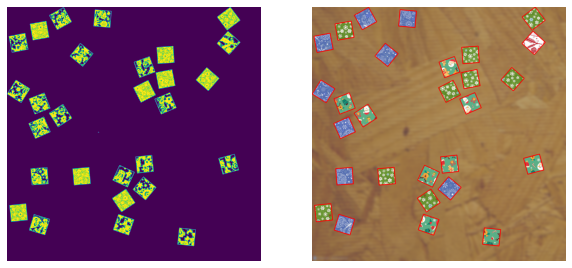

Number of contours found:  96
Number of filtered contours found:  20


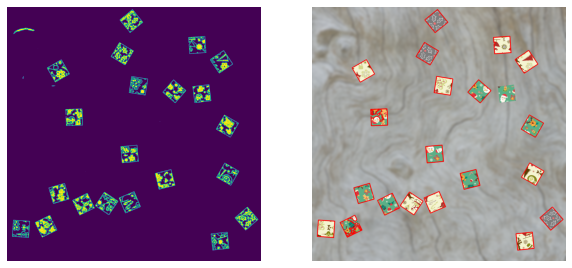

Number of contours found:  67
Number of filtered contours found:  27


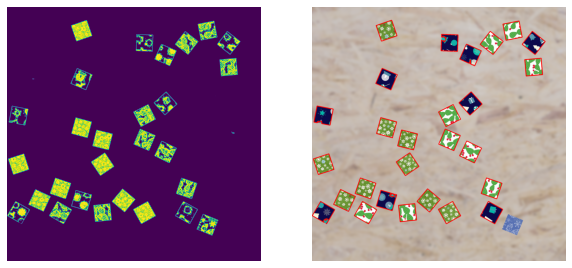

Number of contours found:  21
Number of filtered contours found:  21


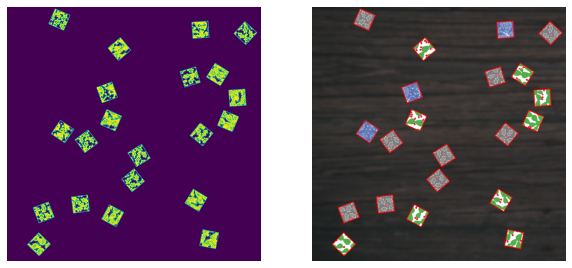

Number of contours found:  72
Number of filtered contours found:  13


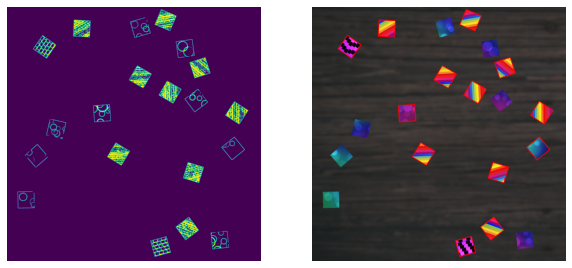

Number of contours found:  76
Number of filtered contours found:  27


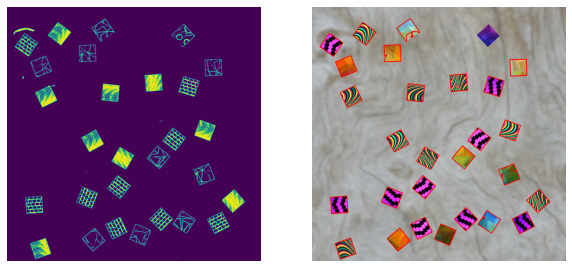

Number of contours found:  30
Number of filtered contours found:  29


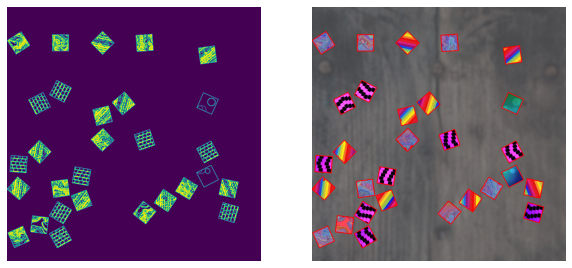

Number of contours found:  31
Number of filtered contours found:  27


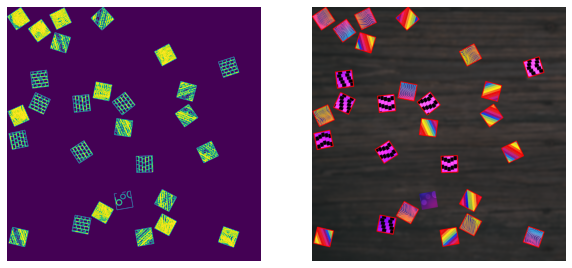

Number of contours found:  35
Number of filtered contours found:  27


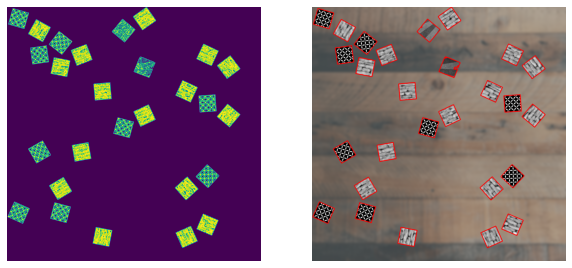

Number of contours found:  87
Number of filtered contours found:  29


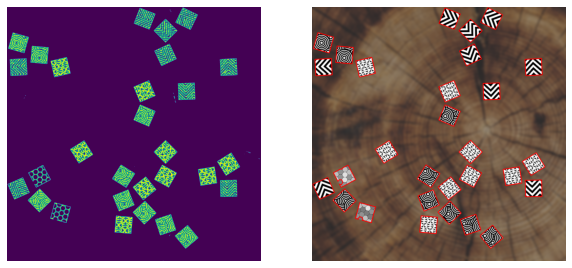

Number of contours found:  192
Number of filtered contours found:  28


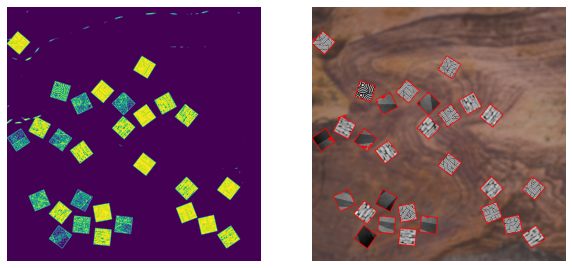

Number of contours found:  387
Number of filtered contours found:  18


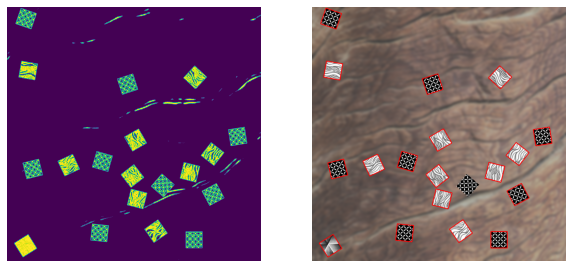

In [104]:
for test_image in test_images:
    try:
        test_segmentation_watershed(cv2.imread(test_image), threshold=0.02)
    except:
        print("Error in image: ", test_image)

## Evaluation metrics

The evaluation metrics will be liberated in the following days. 


## Gabor filters

$$ gb(x,y) = \exp \left( -\frac{1}{2} \left( \frac{x_{\theta}^2}{\sigma^2} + \frac{y_{\theta}^2}{(\Gamma\sigma)^2} \right) \right) \cos \left( \frac{2 \pi}{\lambda} x_{\theta} + \psi \right) $$
